In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)


## Read in `coalmine_eia923`

In [387]:
import sqlalchemy as sa
import pudl

pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

pudl_engine = sa.create_engine("sqlite:////Users/bendnorman/catalyst/pudl-work/sqlite/full_pudl.sqlite") # For testing

with pudl_engine.connect() as con:
    coalmine_eia923 = pd.read_sql_table("coalmine_eia923", con)
    fuel_receipts_costs_eia923 = pd.read_sql_table("fuel_receipts_costs_eia923", con)
    
coalmine_eia923["mine_id_msha"] = coalmine_eia923["mine_id_msha"].astype("Int64")
coalmine_eia923["mine_id_pudl"] = coalmine_eia923["mine_id_pudl"].astype("Int64")
coalmine_eia923["mine_id_msha"]

0          <NA>
1          <NA>
2          <NA>
3          <NA>
4        103150
         ...   
4793    1519099
4794       <NA>
4795    3605018
4796    1103203
4797    3402076
Name: mine_id_msha, Length: 4798, dtype: Int64

In [385]:
coalmine_eia923.mine_id_msha.isna().value_counts(normalize=True)

False    0.583993
True     0.416007
Name: mine_id_msha, dtype: float64

In [300]:
coalmine_eia923.mine_name.isna().value_counts(normalize=True)

False    1.0
Name: mine_name, dtype: float64

In [301]:
coalmine_eia923.mine_id_msha.value_counts()

4601968    10
1516353     9
4800977     8
1518728     7
1513193     7
           ..
1103248     1
1511211     1
4609144     1
4609067     1
1519099     1
Name: mine_id_msha, Length: 1412, dtype: Int64

In [302]:
coalmine_eia923[coalmine_eia923["mine_id_msha"] == 1516353]

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,data_maturity
109,109,shamrock prep 2,SU,KY,21193,1516353,final
119,119,leeco - buckeye 64 prep,SU,KY,21193,1516353,final
890,890,cave branch,S,KY,21193,1516353,final
1376,1376,leeco - buckeye 64 prep,U,KY,21193,1516353,final
2119,2119,64,P,KY,21193,1516353,final
2153,2153,64,SU,KY,21193,1516353,final
2716,2716,buckeye 64,SU,KY,21193,1516353,final
2718,2718,64,SU,KY,None,1516353,final
3658,3658,64,P,KY,None,1516353,final


In [303]:
coalmine_eia923.mine_type_code.value_counts()

S     2292
U     1200
SU     633
P      584
US      75
Name: mine_type_code, dtype: int64

About 42% of coalmines are missing msha ids. The mines that do have msha ids are not unique. This is because the ETL isn't dropping records with duplicate msha ids. The duplicates are likely the same mine being reported in multiple years. Are there specific years that are missing msha ids or are all years missing some data? 

## Add report_date
Add report_date back to the coalmines using the `fuel_receipts_costs_eia923` table.

In [388]:
fuel_receipts_costs_eia923["mine_id_pudl"] = fuel_receipts_costs_eia923["mine_id_pudl"].astype("Int64")
fuel_receipts_costs_eia923["mine_id_pudl"].value_counts()

20      16152
19      11046
21       6136
42       4043
127      4014
        ...  
704         1
4744        1
212         1
683         1
1748        1
Name: mine_id_pudl, Length: 4798, dtype: Int64

In [389]:
mines_with_report_date = coalmine_eia923.merge(fuel_receipts_costs_eia923, on="mine_id_pudl", how="left", validate="1:m")

In [390]:
fields = coalmine_eia923.columns.to_list() + ["report_date"]
fields.remove("data_maturity")
mines_with_report_date = mines_with_report_date[fields]

In [395]:
mines_with_report_date = fuel_receipts_costs_eia923_with_mines.drop_duplicates()

In [396]:
coalmine_eia923_fields = coalmine_eia923.columns.to_list()
coalmine_eia923_fields.remove("data_maturity")
deduped_mines = mines_with_report_date.drop_duplicates(subset=coalmine_eia923_fields)

# make sure we still have the same number of mine entities
assert len(coalmine_eia923) == len(deduped_mines)

<AxesSubplot:xlabel='report_date'>

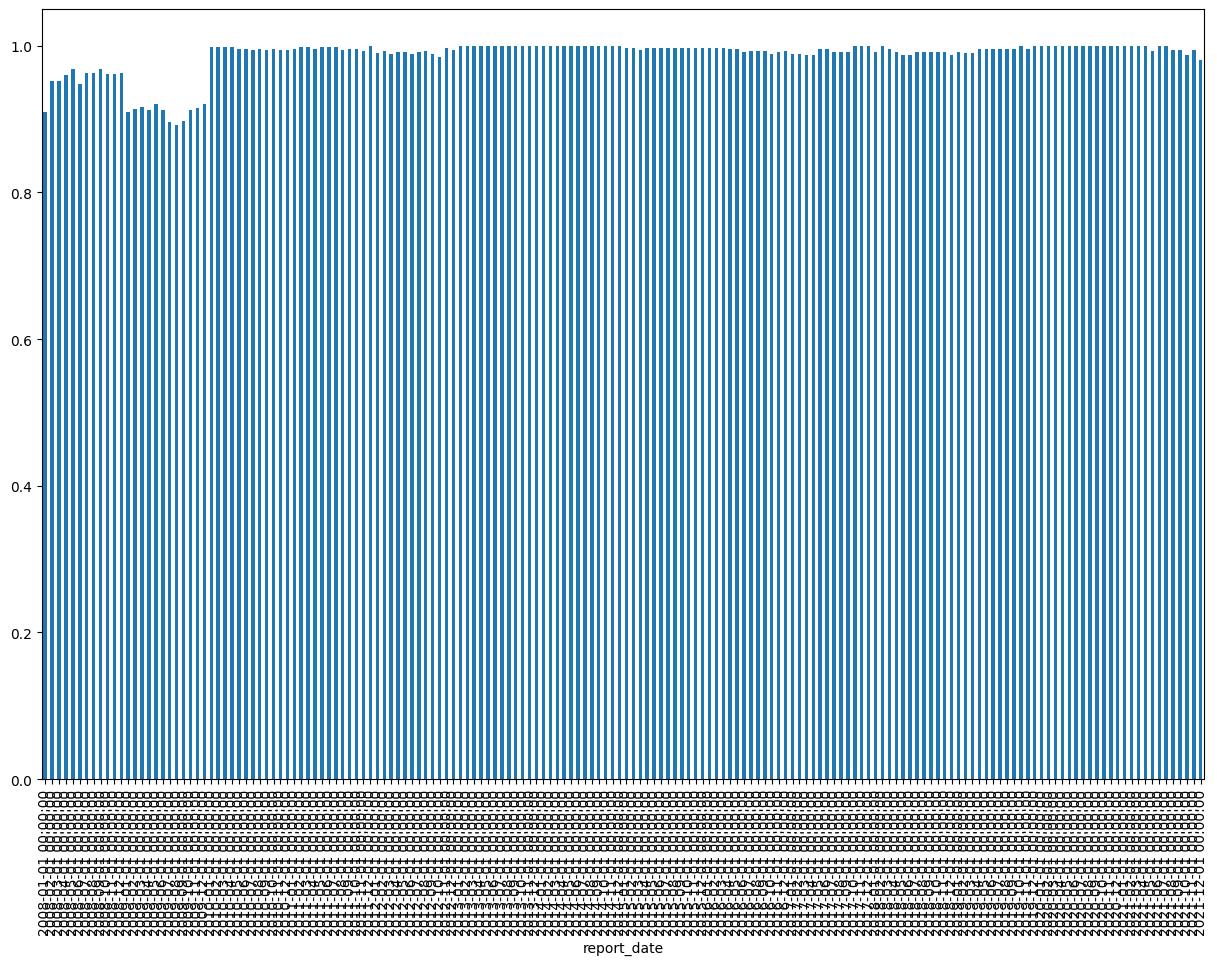

In [397]:
mines_with_report_date_groups = mines_with_report_date.groupby(mines_with_report_date.report_date)


report_date_with_unique_ids = mines_with_report_date_groups.mine_id_msha.nunique() / mines_with_report_date_groups.mine_id_msha.count()
report_date_with_unique_ids.plot.bar(figsize=(15, 10))

In [399]:
report_date_with_unique_ids.describe()

count    168.000000
mean       0.986768
std        0.024505
min        0.892174
25%        0.991189
50%        0.995661
75%        1.000000
max        1.000000
Name: mine_id_msha, dtype: float64

It looks like in most months the msha ids are almost unique. In theory, the MSHA ids should be unique for each month of reporting because the respondents are working with the same MSHA data from EIA. 2008 - 2009 have more duplicate ids than other years.

### evaluate how many mines are missing mine_id_msha
Was the id introduced in a give year? 

In [400]:
mines_with_report_date.mine_id_msha.isna().value_counts()

False    54307
True     12527
Name: mine_id_msha, dtype: int64

<AxesSubplot:xlabel='report_date'>

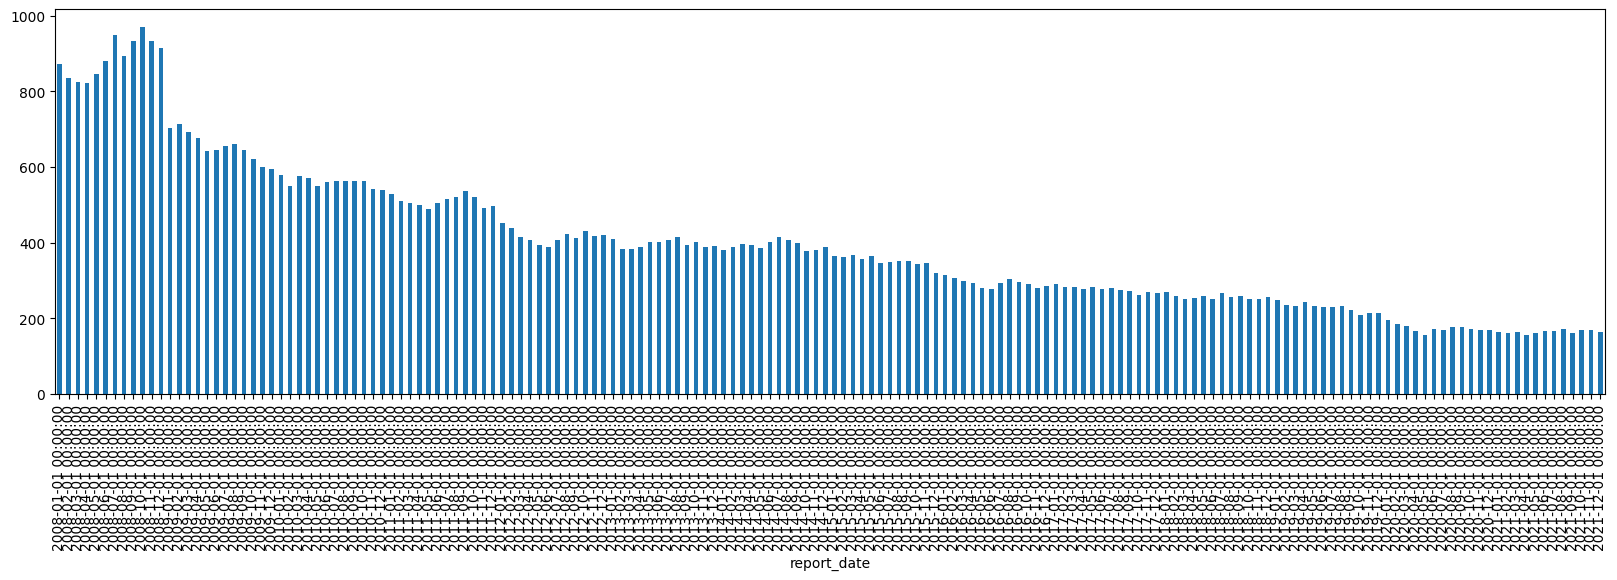

In [401]:
mines_with_report_date.groupby("report_date").count().mine_id_pudl.plot.bar(figsize=(20, 5))

<AxesSubplot:xlabel='report_date'>

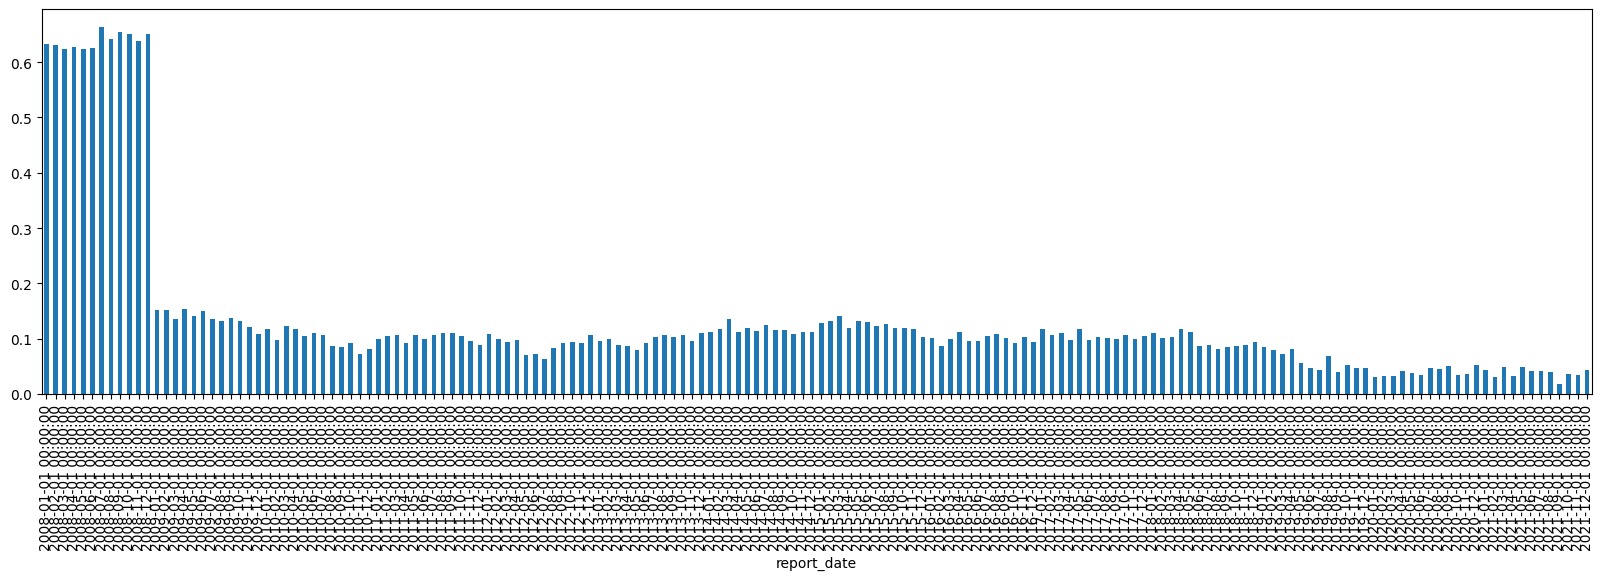

In [402]:
missing_id_by_date = mines_with_report_date.set_index("report_date").mine_id_msha.isna().groupby("report_date")

(missing_id_by_date.sum() / missing_id_by_date.count()).plot.bar(figsize=(20, 5))
# missing_id_by_date.sum().plot.bar(figsize=(20, 5))

It looks like after 2008 ~10% of mines each month are missing MSHA mine ids. This makes me think EIA wasn't giving respondents a set of MSHA values to work with...

The EIA 923 Form has a set of MSHA mines for respondents to choose from. Some of the mines EIA provides do not have MSHA ids. My guess is EIA didn't provide MSHA mines in the Form until 2009. 

In [416]:
one_month_mines = mines_with_report_date[(mines_with_report_date["report_date"] == '2021-11-01')]
one_month_mines.mine_id_msha.isna().value_counts(normalize=True) * 100

False    96.470588
True      3.529412
Name: mine_id_msha, dtype: float64

In [417]:
one_month_mines[one_month_mines.mine_id_msha.isna()]

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
208777,4541,mina pribbenow,S,COL,None,<NA>,2021-11-01
215772,4688,santa marta,S,COL,None,<NA>,2021-11-01
216163,4731,maura pantai,S,IDN,None,<NA>,2021-11-01
216313,4782,variousky-johnfloydmagof mne,S,KY,21153,<NA>,2021-11-01
216315,4783,variousky-johnfloydmagof mne,S,KY,21115,<NA>,2021-11-01
216317,4784,variousky-johnfloydmagof mne,S,KY,21071,<NA>,2021-11-01


## Grab the most recent mine information for each mine_id_msha
A simple way to resolve the duplicate mine ids is to just grab the most recent information for a given msha id.

In [405]:
mines_with_msha_ids = mines_with_report_date[~mines_with_report_date.mine_id_msha.isna()]
mines_without_msha_ids = mines_with_report_date[mines_with_report_date.mine_id_msha.isna()]

mines_with_msha_ids = mines_with_msha_ids.sort_values(by="report_date", ascending=False).groupby("mine_id_msha").head(1)

<AxesSubplot:xlabel='report_date'>

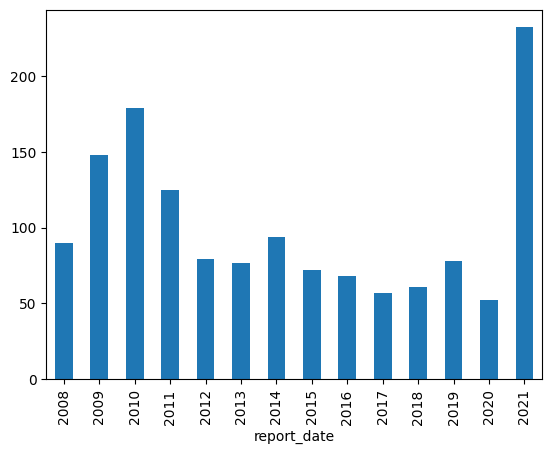

In [406]:
deduped_mines_with_msha_ids.groupby(deduped_mines_with_msha_ids.report_date.dt.year).count().mine_id_pudl.plot.bar()

In [407]:
mine_cols = ['mine_id_pudl', 'mine_name', 'mine_type_code', 'state', 'county_id_fips', 'mine_id_msha']

mines_without_msha_ids = mines_without_msha_ids.drop_duplicates(subset=mine_cols)

<AxesSubplot:>

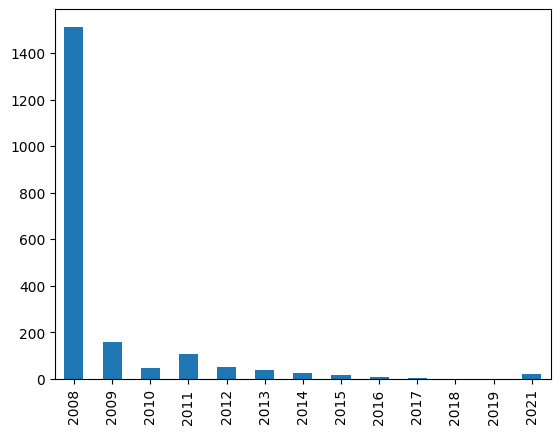

In [408]:
mines_without_msha_ids.report_date.dt.year.value_counts().sort_index().plot.bar()

In [409]:
(mines_without_msha_ids.report_date.dt.year < 2009).value_counts(normalize=True)

True     0.757515
False    0.242485
Name: report_date, dtype: float64

75% of mines with missing MSHA ids are from 2008. 

In [410]:
eia_coalmines = pd.concat([mines_without_msha_ids, mines_with_msha_ids])
eia_coalmines.mine_id_msha.isna().value_counts()

True     1996
False    1412
Name: mine_id_msha, dtype: int64

In [366]:
eia_coalmines.head(30)

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
0,0,mina pribbenow,SU,COL,None,<NA>,2008-01-01
79,1,alabama coal,SU,AL,01007,<NA>,2008-01-01
125,2,flat rock 2,S,AL,01145,<NA>,2008-01-01
137,3,aldridge no 1,S,AL,01127,<NA>,2008-01-01
247,6,aldridge no 1,SU,AL,01127,<NA>,2008-01-01
272,10,kentucky -cumberland,SU,KY,21095,<NA>,2008-01-01
322,12,rock mountain mine,SU,AL,01127,<NA>,2008-01-01
39689,31,coal creek mine,S,WY,56005,<NA>,2008-01-01
39701,32,black thunder,U,WY,56005,<NA>,2008-01-01
39773,33,eagle butte mine,U,WY,56005,<NA>,2008-01-01


In [367]:
eia_coalmines[eia_coalmines.mine_name.str.contains("fanco", na=False)]

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
60395,76,fanco,S,WV,54045,<NA>,2008-01-01
84247,370,fanco wv,SU,WV,54045,<NA>,2008-01-01
107781,1268,fanco,SU,WV,54045,<NA>,2008-05-01
107787,1272,fanco,US,WV,54045,<NA>,2008-05-01
110650,1497,fanco,S,WV,54039,<NA>,2008-07-01
110672,1507,fancomine co,S,WV,54045,<NA>,2008-07-01
110673,1508,fancomine co,S,KY,21071,<NA>,2008-07-01
111077,1592,fanco load,S,WV,54045,<NA>,2008-07-01
111079,1594,fanco loadout,S,WV,54039,<NA>,2008-07-01
111100,1602,fanco loadout,S,KY,21071,<NA>,2008-07-01


### Mines with MSHA ids 
- 'coal creek' has a new mine_id_msha
- 'black thunder'
- 'eagle butte mine'
- 'mc clane canyon mine'
- 'north anteloperochelle' but with a typo
- 'new horizon mine'
- 'scotts branch'
### Mines without MSHA ids
- 'sigmon'
- 'ben creek'
- 'wellmore strickland' maybe?!
- 'edna ruth' maybe
- 'toms fork' maybe
- 'winifrede jct' maybe
- 'elk run'

## Resolve some duplicates with exact matching
Fill in some missing msha ids where there is an exact match with the mine_name and the county_id_fips. 

In [445]:
eia_coalmines = pd.concat([deduped_mines_without_msha_ids, deduped_mines_with_msha_ids])
eia_coalmines.mine_id_msha.isna().value_counts(normalize=True)

True     0.585802
False    0.414198
Name: mine_id_msha, dtype: float64

In [446]:
eia_coalmines.duplicated(subset=["county_id_fips", "mine_name"]).value_counts()

False    2899
True      510
dtype: int64

In [447]:
is_duplicate_mine = eia_coalmines.duplicated(subset=["county_id_fips", "mine_name"], keep=False) & eia_coalmines.mine_id_msha.isna()
is_duplicate_mine.value_counts()

False    2626
True      783
dtype: int64

In [448]:
eia_coalmines = eia_coalmines[~is_duplicate_mine]
eia_coalmines.mine_id_msha.isna().value_counts(normalize=True)

False    0.5377
True     0.4623
Name: mine_id_msha, dtype: float64

<AxesSubplot:>

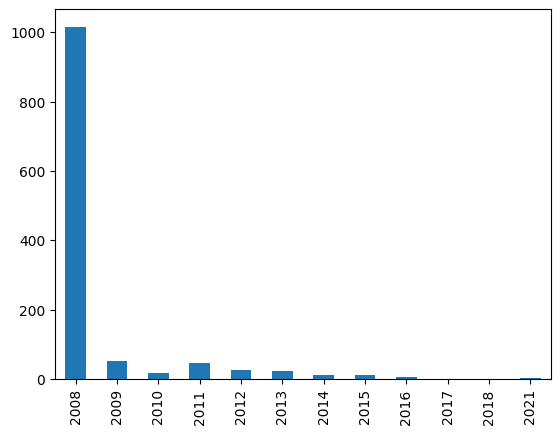

In [449]:
eia_coalmines[eia_coalmines.mine_id_msha.isna()].report_date.dt.year.value_counts().sort_index().plot.bar()

Using exact matching the percent of coalmines missing msha ids went from 59% to 46%. Most of the mines missing MSHA ids are still in 2008. This could be improved by doing fuzzy string comparisons between mine names in the same county. 

## Entity Resolution (WIP)

In [545]:
# eia_coalmines = pd.concat([mines_without_msha_ids, mines_with_msha_ids])
mines_without_msha_ids = eia_coalmines[eia_coalmines.mine_id_msha.isna()]
mines_with_msha_ids = eia_coalmines[~eia_coalmines.mine_id_msha.isna()]

In [585]:
import recordlinkage
from recordlinkage.datasets import load_febrl1

# Indexation step
indexer = recordlinkage.Index()
indexer.block(left_on="county_id_fips")
candidate_links = indexer.index(mines_without_msha_ids, mines_with_msha_ids)

# Comparison step
compare_cl = recordlinkage.Compare()

compare_cl.exact("county_id_fips", "county_id_fips", label="county_id_fips")
compare_cl.exact("mine_type_code", "mine_type_code", label="mine_type_code")
# compare_cl.exact("mine_id_msha", "mine_id_msha", label="mine_id_msha", missing_value=1)
compare_cl.string("mine_name", "mine_name", method="jarowinkler", threshold=0.85, label="surname")
features = compare_cl.compute(candidate_links, mines_without_msha_ids, mines_with_msha_ids)

<AxesSubplot:ylabel='Frequency'>

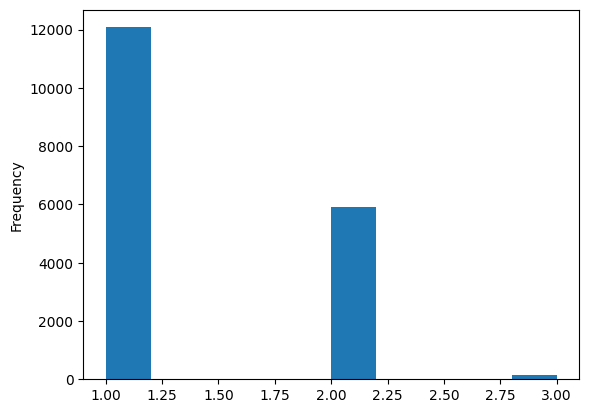

In [586]:
features.sum(axis=1).plot.hist()

In [588]:
# Classification step
matches = features[features.sum(axis=1) >= 3]
print(len(matches))

131


In [589]:
matches

,,county_id_fips,mine_type_code,surname
40126,117512,1,1,1.0
46785,117512,1,1,1.0
1432,98745,1,1,1.0
10254,602311,1,1,1.0
31676,388840,1,1,1.0
...,...,...,...,...
47115,122742,1,1,1.0
34222,76122,1,1,1.0
36463,383522,1,1,1.0
41166,535096,1,1,1.0


In [590]:
matches

,,county_id_fips,mine_type_code,surname
40126,117512,1,1,1.0
46785,117512,1,1,1.0
1432,98745,1,1,1.0
10254,602311,1,1,1.0
31676,388840,1,1,1.0
...,...,...,...,...
47115,122742,1,1,1.0
34222,76122,1,1,1.0
36463,383522,1,1,1.0
41166,535096,1,1,1.0


In [592]:
display(mines_without_msha_ids.loc[[40126]])
mines_with_msha_ids.loc[[117512]]

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
40126,1748,highsplont,U,KY,21095,<NA>,2008-08-01


,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
117512,852,highsplint,U,KY,21095,1518196,2009-12-01


In [593]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(matches.index.to_list())

components = [com for com in nx.connected_components(G)]

In [601]:
components

[{40126, 46785, 117512},
 {1432, 98745},
 {10254, 602311},
 {31676, 388840},
 {43371, 119093},
 {47820, 546175},
 {58093, 259788},
 {215, 57171, 118086, 177212, 600776},
 {2076, 601674},
 {2780, 601055, 601649},
 {12378, 57175, 600801},
 {17481, 565341},
 {17482, 49114, 59344, 600987},
 {25363, 600754},
 {49120, 600782},
 {1449, 39371, 93708},
 {336, 15137, 516025},
 {22382, 264046, 352436},
 {546, 12279, 389049},
 {2747, 67820, 392738},
 {25424, 539245},
 {2015, 7041, 601317},
 {911, 323315},
 {923, 575585},
 {53520, 601507},
 {914, 177033},
 {915, 324560},
 {1067, 583403},
 {17500, 601136},
 {12173, 92688},
 {2919, 602459},
 {8744, 8776, 601799},
 {27886, 277302},
 {15114, 601314},
 {33156, 328396},
 {1189, 483672},
 {1351, 2006, 5986, 400095},
 {1566, 7553, 600948},
 {6672, 600763},
 {1355, 42810, 590362},
 {1990, 7033, 460525},
 {2329, 2334, 413886},
 {20913, 601094},
 {3801, 601049},
 {42559, 390179},
 {2243, 12084, 434346},
 {27342, 324578},
 {1512, 601647},
 {336133, 384720},
 {

In [602]:
eia_coalmines.loc[list(components[7])]

,mine_id_pudl,mine_name,mine_type_code,state,county_id_fips,mine_id_msha,report_date
118086,125,north antelope mine,S,WY,56005,4801375,2009-12-01
600776,4555,north antelope rochelle mine,S,WY,56005,4801353,2021-12-01
57171,2012,north antelop mine,S,WY,56005,<NA>,2008-12-01
215,58,north anteloperochelle,S,WY,56005,<NA>,2008-01-01
177212,2848,north antelope rochelle mine,S,WY,56005,48011353,2010-12-01
